In [1]:
!pip install Pillow --quiet
!pip install webdataset==0.1.62
!pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from utils import *
import torch
import webdataset as wds
from itertools import islice
import struct, ast
from importlib_metadata import version
from pytorch_model_summary import summary

In [3]:
version('webdataset')

'0.1.62'

In [4]:
class Logger():
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{self.experiment_name}-{info}")
        
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)


def selectLabel(x,lbl):
    # # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")
    # return x if lbl_idx == 0 else float(x)
    return 1
    
s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

using device: cpu


In [5]:
# use mnist to test
mnist_train = torchvision.datasets.MNIST('./mnist', download=True, transform = transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./mnist', train=False, download=True, transform = torchvision.transforms.ToTensor())

In [28]:
class VAE(nn.Module): 
    
    def __init__(self, latent_dim):
        # latent_dim: dimension of the latent representation vector
        super().__init__()
        self.latent_dim = latent_dim
        
        encoder_l = [self.encoder_conv_block(True)]
        for i in range(1):
            encoder_l.append(self.encoder_conv_block())
#         encoder_l.append(self.encoder_conv_block(False, 32, 32, 3, 1, 0))
        encoder_l.append(nn.Flatten())
        self.encoder_before_last = nn.ModuleList(encoder_l)
        #self.encoder_mu = self.encoder_linear_block(960,latent_dim)
        #self.encoder_sigma = self.encoder_linear_block(960, latent_dim)
        self.encoder_mu = self.encoder_linear_block(392,latent_dim)
        self.encoder_sigma = self.encoder_linear_block(392, latent_dim)
        
#        decoder_l = [self.decoder_linear_block(latent_dim, 960)]
        decoder_l = [self.decoder_linear_block(latent_dim, 392)]
#         decoder_l.append(self.decoder_conv_block(False, 32, 32, 3, 1, 0))
        for i in range(1):
            decoder_l.append(self.decoder_conv_block())
        decoder_l.append(self.decoder_conv_block(True))
        self.decoder = nn.ModuleList(decoder_l)
    
    def encoder_conv_block(self, is_start=False, in_channels=8, out_channels=8, kernel_size=6, stride=2, padding=2):
        if is_start:
            return nn.Sequential(
                nn.Conv2d(1, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
    def encoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def decoder_conv_block(self, is_last=False, in_channels=8, out_channels=8, kernel_size=6, stride=2, padding=2):
        if is_last:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, 1, kernel_size, stride, padding),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU()
            )
    
    def decoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def forward(self, x):
        z, mu, sigma = self.encode(x)
        x = self.decode(z)
            
        return x, mu, sigma
    
    def encode(self,x):
        for f in self.encoder_before_last:
            x = f(x)

        mu = self.encoder_mu(x)
        sigma = self.encoder_sigma(x)
        z = self.sample_z(mu, sigma)
        
        return z, mu, sigma
    
    def decode(self,z):
        x = self.decoder[0](z) # pass through the linear layer
#         x = x.view(-1, 32, 1, 30) # reshape the tensor to be expected dimension for ConvTranspose
        x = x.view(-1, 8, 7, 7) # reshape the tensor to be expected dimension for ConvTranspose
        for i in range(1,len(self.decoder)):
            f = self.decoder[i]
            x = f(x) 
            
        return x
    
    def sample_z(self, mu, sigma):
        # Input
        #     mu:     [batch_size, self.latent_size] the predicted mu value for each sample in the batch
        #     sigma:  [batch_size, self.latent_size] the predicted diag elem of sigma value for each sample in the batch
        # Output
        #     z: [batch_size, self.latent_size] the latent representation of each sample in the batch
        # Reference: https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/
        
        # eps ~ N(0,1)        
        batch_size = mu.size()[0]
        eps = torch.randn((batch_size,1), device=device, dtype=dtype)
        z = mu + sigma/2*eps
        
        return z
        

In [25]:
vae = VAE(10)
sample = mnist_train[0][0]
print(sample.shape)
print(summary(vae, torch.unsqueeze(sample,0), show_input=False))

torch.Size([1, 28, 28])
--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1      [1, 8, 14, 14]             296             296
               ReLU-2      [1, 8, 14, 14]               0               0
             Conv2d-3        [1, 8, 7, 7]           2,312           2,312
               ReLU-4        [1, 8, 7, 7]               0               0
            Flatten-5            [1, 392]               0               0
             Linear-6             [1, 10]           3,930           3,930
               ReLU-7             [1, 10]               0               0
             Linear-8             [1, 10]           3,930           3,930
               ReLU-9             [1, 10]               0               0
            Linear-10            [1, 392]           4,312           4,312
              ReLU-11            [1, 392]               0               0
   ConvTransp

KL divergence loss
![kl_loss](https://github.com/dungscout96/deep-representation-learning-EEG/blob/master/images/kl_loss.png?raw=1)

In [47]:
def beta_vae_loss(mu_hat, sigma_hat, x_hat, x_target):
    likelihood_loss = F.mse_loss(x_hat, x_target)
    kl_loss = torch.mean(-0.5 * torch.sum(1 + sigma_hat - torch.exp(sigma_hat) - mu_hat ** 2, dim=1), dim=0)
    return likelihood_loss + 1*kl_loss # average the loss of batch

def train(model, loader_train, optimizer, loader_val, epochs, logger, device, dtype):
    """ 
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - logger: Logger object for logging purpose
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_array = []
    num_batch = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print('Begin trainning...')
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            if e == 0:
                num_batch += 1
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x_hat, mu_hat, sigma_hat = model(x)
            
            loss = beta_vae_loss(mu_hat, sigma_hat, x_hat, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_array.append(loss.item())
            if t % 100 == 0:
                # logger.writer.add_scalar("Loss/train", loss.item(), e*num_batch+t)
                # logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                print(f'Epoch {e}, Iteration {t}, loss = {loss.item()}')
#         train_acc = check_accuracy(loader_train, 'train', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/train", train_acc, e)        
        # get validation loss
#         model.eval()
#         val_loss = check_accuracy(loader_val, 'val', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/valid", val_acc, e)        
#         logger.log()
        
        # Save model per fixed epoch interval
        if e > 0 and e % 10 == 0:
            torch.save(model.state_dict(),f'temp_model_epoch{41+e}')
#             logger.save_model(model,f"epoch{e}")
#         elif val_acc >= 0.83:
#             logger.save_model(model,f"valacc83-epoch{e}")
#         elif val_acc >= 0.84:
#             logger.save_model(model,f"valacc84-epoch{e}")
    # save final model
#     logger.save_model(model,f"epoch{e}")
    return model, loss_array

In [48]:
vae = VAE(10)
# vae.load_state_dict(torch.load(f'temp_model_epoch11-40'))
logger = Logger()
logger.set_model_save_location('VAE')
seed = 0
experiment = f'VAE-seed{seed}-mnist'
# logger.set_experiment(experiment)

batch_size = 128
loader_train = DataLoader(mnist_train, batch_size=batch_size)
loader_val = DataLoader(mnist_test, batch_size=batch_size)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

np.random.seed(seed)
torch.manual_seed(seed)

# trained_model, loss_values = train(vae, loader_train, optimizer, loader_val, 30, logger, device, dtype)
trained_model, loss_values = train(vae, loader_train, optimizer, loader_val, 50, logger, device, dtype)
# from google.colab import files
# np.save('losses.npy',loss_values)
# torch.save(trained_model.state_dict(),'vae_10_epochs')
# files.download('vae_10_epochs') 
# files.download('losses.npy')

Begin trainning...
Epoch 0, Iteration 0, loss = 0.1010081097483635
Epoch 0, Iteration 100, loss = 0.0861983448266983


KeyboardInterrupt: 

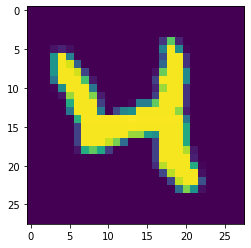

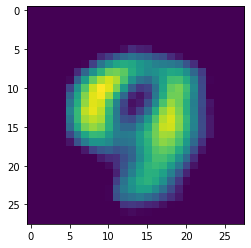

In [17]:
sample = mnist_train[20][0]
plt.imshow(torch.squeeze(sample))
plt.figure()
mu_hat, sigma_hat, x_hat = trained_model(torch.unsqueeze(sample,0))
plt.imshow(torch.squeeze(torch.squeeze(x_hat)).detach())

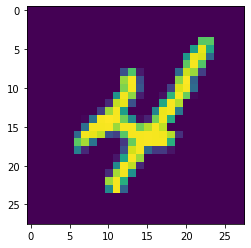

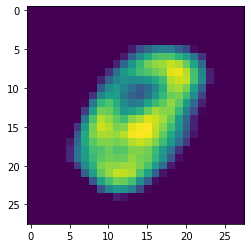

In [154]:
sample = mnist_train[9][0]
plt.imshow(torch.squeeze(sample))
plt.figure()
mu_hat, sigma_hat, x_hat = vae(torch.unsqueeze(sample,0))
plt.imshow(torch.squeeze(torch.squeeze(x_hat)).detach())

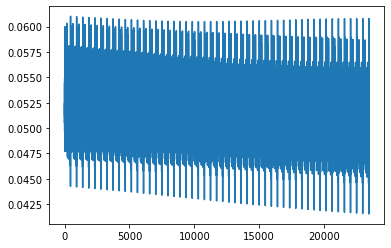

In [18]:
plt.plot(loss_values)

In [29]:
vae = VAE(10)
vae.load_state_dict(torch.load(f'temp_model_epoch81'))

<All keys matched successfully>

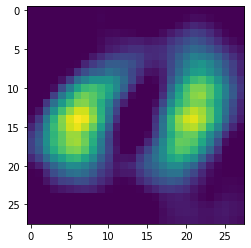

In [45]:
torch.manual_seed(70)
random_sample = vae.decode(torch.rand((1,10)))
plt.imshow(torch.squeeze(torch.squeeze(random_sample)).detach())